<h1 style="text-align: center;">Testing MC Notebook</h1>
<h3 style="text-align: center;">Diego Ontiveros</h3>

<center>In this notebook general plots of the different runs and potentials are gathered. Also, different aspects of the Monte Carlo program are tested separatedly to secure all works well and is as optimized as possible.</center>

In [1]:
from itertools import combinations
from math import comb
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import os
%matplotlib inline

Below are the functions used for calculating the He-He and He-Li potentials, parametrized from refA and refB, respectively.

In [2]:

def fnHeLi(R,n,b):
    suma = np.sum([(b*R)**k /np.math.factorial(k) for k in range(n+1)],axis=0)
    # k = np.arange(n+1)
    # suma = np.sum( (b*R)**k/sp.special.factorial(k) ) # broadcastin!
    return 1 - np.exp(-b*R) * suma

def fnHeHe(x,D):
    return np.exp(-(D/x-1)**2)


def HeLiPotential(R):
    """
    Computes the He-Li potential asi in Chem. Phys. Lett. (2001), 343, 429-436.

    Parameters
    ----------
    `R` : Distance between He-Li particles.

    Returns
    -------
    `V` He-Li potential in cm-1.
    """

    # Faster power calculations
    R2 = R*R
    R4 = R2*R2
    R6 = R4*R2
    R7 = R6*R
    R8 = R4*R4

    # Parametrized coefitients
    A,b = 20.8682, 2.554
    D4 = 1.383192/2
    D6 = 2.4451/2 + 0.298
    D7 = 7.3267/2
    D8 = 10.6204/2 + 43.104/24 + 1.98
    
    V4 = fnHeLi(R,4,b)*D4/R4
    V6 = fnHeLi(R,6,b)*D6/R6
    V7 = fnHeLi(R,7,b)*D7/R7
    V8 = fnHeLi(R,8,b)*D8/R8

    V = A*np.exp(-b*R) - V4 - V6 - V7 - V8
    cm = 219474.63
    return V*cm

def HeHePotential(R):
    """
    Computes the LM2M2 He-He potential.

    Parameters
    ----------
    `R` : Distance between He particles.

    Returns
    -------
    `V` : He-He potential in cm-1.
    """
    eps = 10.97
    rm = 2.9695/0.529177
    x = R/rm

    # Faster power calculations
    x2 = x*x
    x6 = x2*x2*x2
    x8 = x6*x2
    x10 = x8*x2

    # Parametrized coefitients
    A = 1.89635353e5
    a,b = 10.70203539, -1.90740649
    D6,D8,D10 = 1.4651625, 1.2, 1.1
    c6, c8, c10 = 1.34687065, 0.41308398, 0.17060159

    f6 = fnHeHe(x,D6)
    f8 = fnHeHe(x,D8)
    f10 = fnHeHe(x,D10)

    Vx = A*np.exp(-a*x+b*x**2) - f6*c6/x6 -f8*c8/x8 - f10*c10/x10 
    V = eps*Vx
    cm = 219474.63
    K = 315777
    return V*cm/K


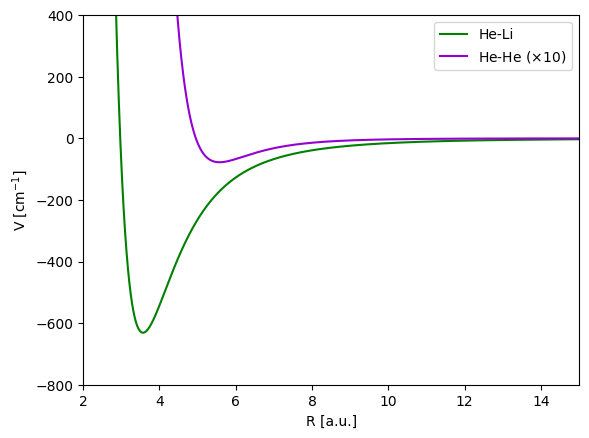

In [3]:
# Representation of He-Li and He-He potentials.
R = np.linspace(2,15,10000)
VHeHe = HeHePotential(R)
VHeLi = HeLiPotential(R)
plt.plot(R,VHeLi,c="green",label="He-Li")
plt.plot(R,VHeHe*10,c="darkviolet",label="He-He ($\\times$10)")
plt.xlim(R[0],R[-1])
plt.ylim(-800,400)
plt.xlabel("R [a.u.]");plt.ylabel("V [cm$^{-1}$]")
plt.legend()
plt.savefig("potentials.jpg",dpi=600)


In [4]:
RminHeHe = R[np.argmin(VHeHe)]
RminHeLi = R[np.argmin(VHeLi)]
VminHeHe = np.min(VHeHe)
VminHeLi = np.min(VHeLi)
print("Equilibrium He-He distance (a.u.): ",RminHeHe)
print("Equilibrium He-Li distance (a.u.): ",RminHeLi)

print("Minimum He-He energy (cm-1): ",VminHeHe)
print("Minimum He-Li energy (cm-1): ",VminHeLi)

Equilibrium He-He distance (a.u.):  5.575357535753575
Equilibrium He-Li distance (a.u.):  3.569256925692569
Minimum He-He energy (cm-1):  -7.767317239616408
Minimum He-Li energy (cm-1):  -631.1863815237182


In [5]:
def comb(N,m):
    return sp.special.factorial(N)/(sp.special.factorial(m)*sp.special.factorial(N-m))

def minimum(N_He):
    HeLi_pairs = VminHeLi*N_He
    HeHe_pairs = VminHeHe*comb(N_He,2)
    ideal_minim = HeLi_pairs+HeHe_pairs
    return ideal_minim


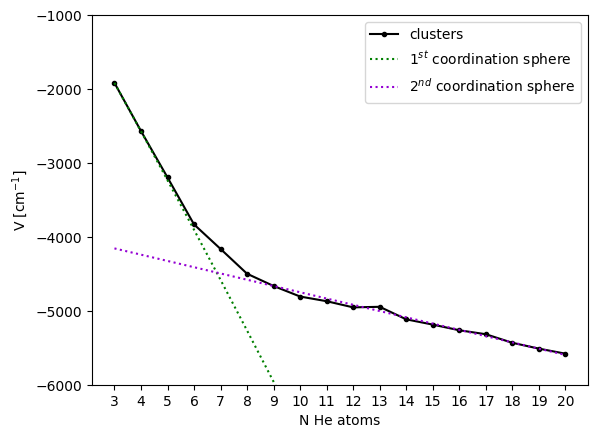

In [6]:
# Energies of the different runs
target = "Minimum energy found"
runs = os.listdir("./runs/")
energies = []

N_He = np.arange(3,20+1)
for i in N_He:
    try: 
        path = f"./runs/He{i}Li/out{i}.log"
        with open(path,"r") as inFile:
            for line in inFile:
                if target in line:
                    minE = line.strip().split()[-1]
                    energies.append(float(minE))
    except FileNotFoundError: pass
energies = np.array(energies)
second_sphere = energies[5:]
a,b = np.polyfit(N_He[5:],energies[5:],1)
second_sphere = a*N_He+b
m = minimum(N_He)

tick_step = 1
plt.plot(N_He,energies,"-k.",label="clusters")
plt.plot(N_He,m,"g:",label="1$^{st}$ coordination sphere")
plt.plot(N_He,second_sphere,":",c="darkviolet",label="2$^{nd}$ coordination sphere")
plt.xlabel("N He atoms");plt.ylabel("V [cm$^{-1}$]")
plt.ylim(ymin=-6000,ymax=-1000)
plt.xticks(np.arange(N_He[0], N_He[-1]+tick_step, tick_step))
plt.legend()
plt.savefig("energies.jpg",dpi=600)

Testing visualization of coordinates

In [7]:
def draw(coord,ax:plt.Axes):
    ax.scatter(*coord, s=100, c="r", alpha=True)

Text(0.5, 0, 'z')

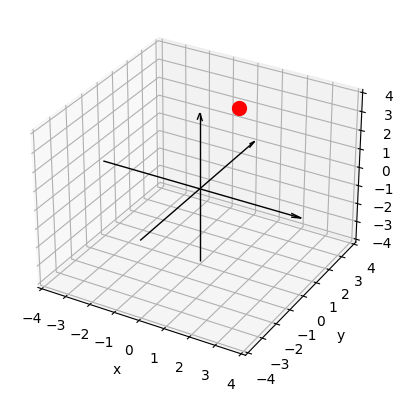

In [8]:
coord = np.array([1,1,4])

# Testing Visualization
fig = plt.figure()
ax = plt.axes(projection="3d")
draw(coord,ax)


lim = 4 #box limit
ax.quiver(-lim, 0, 0, 2*lim, 0, 0, color='k',lw=1, arrow_length_ratio=0.05)     # x-axis
ax.quiver(0, -lim, 0, 0, 2*lim, 0, color='k',lw=1, arrow_length_ratio=0.05)     # y-axis
ax.quiver(0, 0, -lim, 0, 0, 2*lim, color='k',lw=1, arrow_length_ratio=0.05)     # z-axis
ax.set_xlim(-lim,lim);ax.set_ylim(-lim,lim);ax.set_zlim(-lim,lim)               # Box limits
ax.set_xlabel("x");ax.set_ylabel("y");ax.set_zlabel("z")                        # Axis Labels